<a href="https://colab.research.google.com/github/osgeokr/torchgeo-explained/blob/main/TorchGeo%EB%A5%BC%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20%EA%B0%9D%EC%B2%B4%20%ED%83%90%EC%A7%80(Object%20Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchgeo

In [ ]:
torchgeo.__version__

'0.6.0.dev0'

In [ ]:
import torch
from torchgeo.trainers import ObjectDetectionTask
from torchgeo.datasets import VHR10
from torch.utils.data import DataLoader
import lightning.pytorch as pl
import matplotlib.pyplot as plt

In [ ]:
def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample

ds = VHR10(root='data/VHR10/', split='positive', transforms=preprocess, download=True)

Files already downloaded and verified
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
len(ds)

650

In [ ]:
ds[0]

{'image': tensor([[[0.3059, 0.3059, 0.3098,  ..., 0.3765, 0.3686, 0.3647],
          [0.3020, 0.3020, 0.3098,  ..., 0.3804, 0.3725, 0.3686],
          [0.2941, 0.2980, 0.3059,  ..., 0.3804, 0.3686, 0.3569],
          ...,
          [0.4431, 0.4431, 0.4471,  ..., 0.3373, 0.3333, 0.3333],
          [0.4431, 0.4431, 0.4471,  ..., 0.3373, 0.3333, 0.3294],
          [0.4392, 0.4431, 0.4431,  ..., 0.3412, 0.3333, 0.3294]],
 
         [[0.3490, 0.3490, 0.3529,  ..., 0.4275, 0.4196, 0.4157],
          [0.3451, 0.3451, 0.3529,  ..., 0.4314, 0.4235, 0.4196],
          [0.3333, 0.3373, 0.3451,  ..., 0.4314, 0.4196, 0.4078],
          ...,
          [0.4941, 0.4941, 0.4980,  ..., 0.3569, 0.3529, 0.3529],
          [0.4941, 0.4941, 0.4980,  ..., 0.3569, 0.3529, 0.3490],
          [0.4902, 0.4941, 0.4941,  ..., 0.3608, 0.3529, 0.3490]],
 
         [[0.1922, 0.1922, 0.1961,  ..., 0.3098, 0.3098, 0.3059],
          [0.1882, 0.1882, 0.1961,  ..., 0.3137, 0.3137, 0.3098],
          [0.1882, 0.1922, 0.20

In [ ]:
ds[0]["image"].shape, ds[1]["image"].shape

(torch.Size([3, 808, 958]), torch.Size([3, 806, 950]))

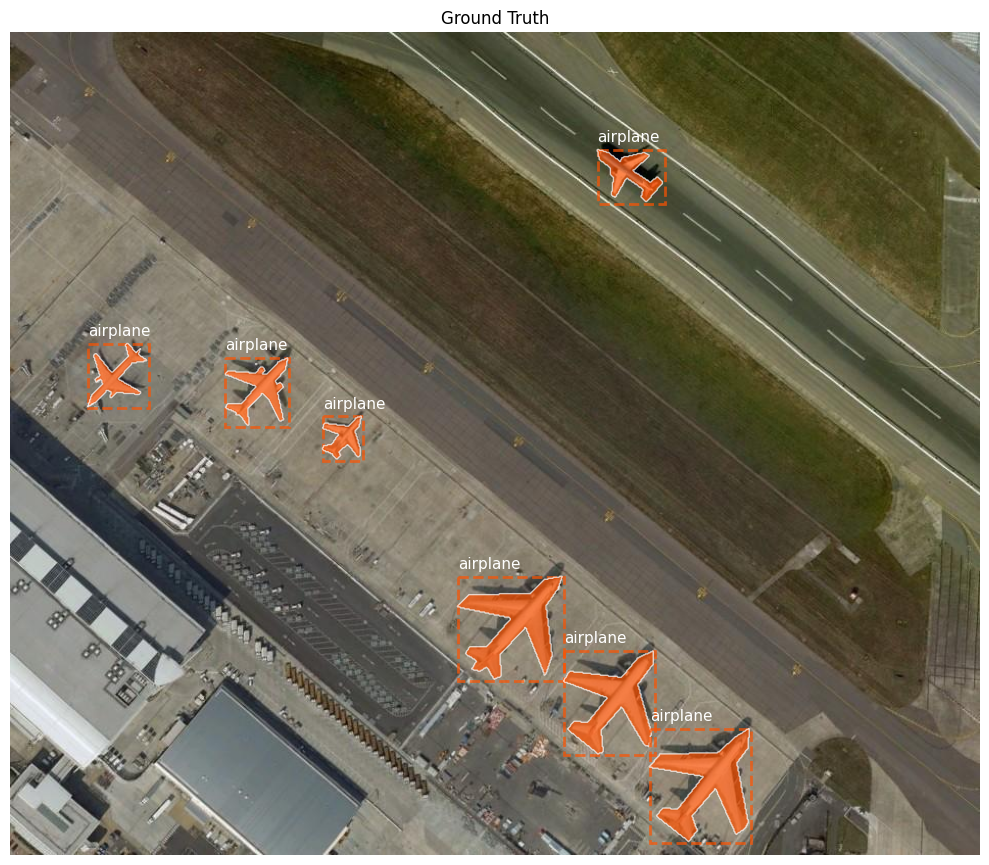

In [ ]:
ds.plot(ds[1])
plt.show()
plt.close()

In [ ]:
def collate_fn(batch):
    new_batch = {
        "image": [item["image"] for item in batch],
        "boxes": [item["boxes"] for item in batch],
        "labels": [item["labels"] for item in batch],
        "masks": [item["masks"] for item in batch],
    }
    return new_batch

dl = DataLoader(ds, batch_size=32, num_workers=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
# The current (torchgeo 0.5.0) ObjectDetectionTask does not seem to support variable
# size inputs. We can quickly fix this by subclassing it and overriding the
# training_step method.
class VariableSizeInputObjectDetectionTask(ObjectDetectionTask):
    def training_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch["image"]
        batch_size = len(x)  # we change this line to support variable size inputs
        y = [
            {"boxes": batch["boxes"][i], "labels": batch["labels"][i]}
            for i in range(batch_size)
        ]
        loss_dict = self(x, y)
        train_loss: Tensor = sum(loss_dict.values())
        self.log_dict(loss_dict)
        return train_loss


task = VariableSizeInputObjectDetectionTask(
    model="faster-rcnn",
    backbone="resnet18",
    weights=True,
    in_channels=3,
    num_classes=11,
    trainable_layers=3,
    lr=1e-3,
    patience=10,
    freeze_backbone=False,
)
task.monitor = "loss_classifier"

In [ ]:
trainer = pl.Trainer(
    default_root_dir="logs/",
    accelerator="gpu",
    devices=[0],
    min_epochs=6,
    max_epochs=100,
    log_every_n_steps=20,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(task, train_dataloaders=dl)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/home/calebrobinson/.conda/envs/geospatiallib/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type             | Params
--------------------------------------------------
0 | val_metrics  | MetricCollection | 0     
1 | test_metrics | MetricCollection | 0     
2 | model

Training: 0it [00:00, ?it/s]

## Inference example

In [ ]:
batch = next(iter(dl))
#batch["image"] = [image.to("cuda:0") for image in batch["image"]]

In [ ]:
model = task.model
model.eval()

with torch.no_grad():
    out = model(batch["image"])

In [ ]:
batch_idx = 0
sample = {
    "image": batch["image"][batch_idx],
    "boxes": batch["boxes"][batch_idx],
    "labels": batch["labels"][batch_idx],
    "masks": batch["masks"][batch_idx],
    "prediction_labels": out[batch_idx]["labels"],
    "prediction_boxes": out[batch_idx]["boxes"],
    "prediction_scores": out[batch_idx]["scores"],
}

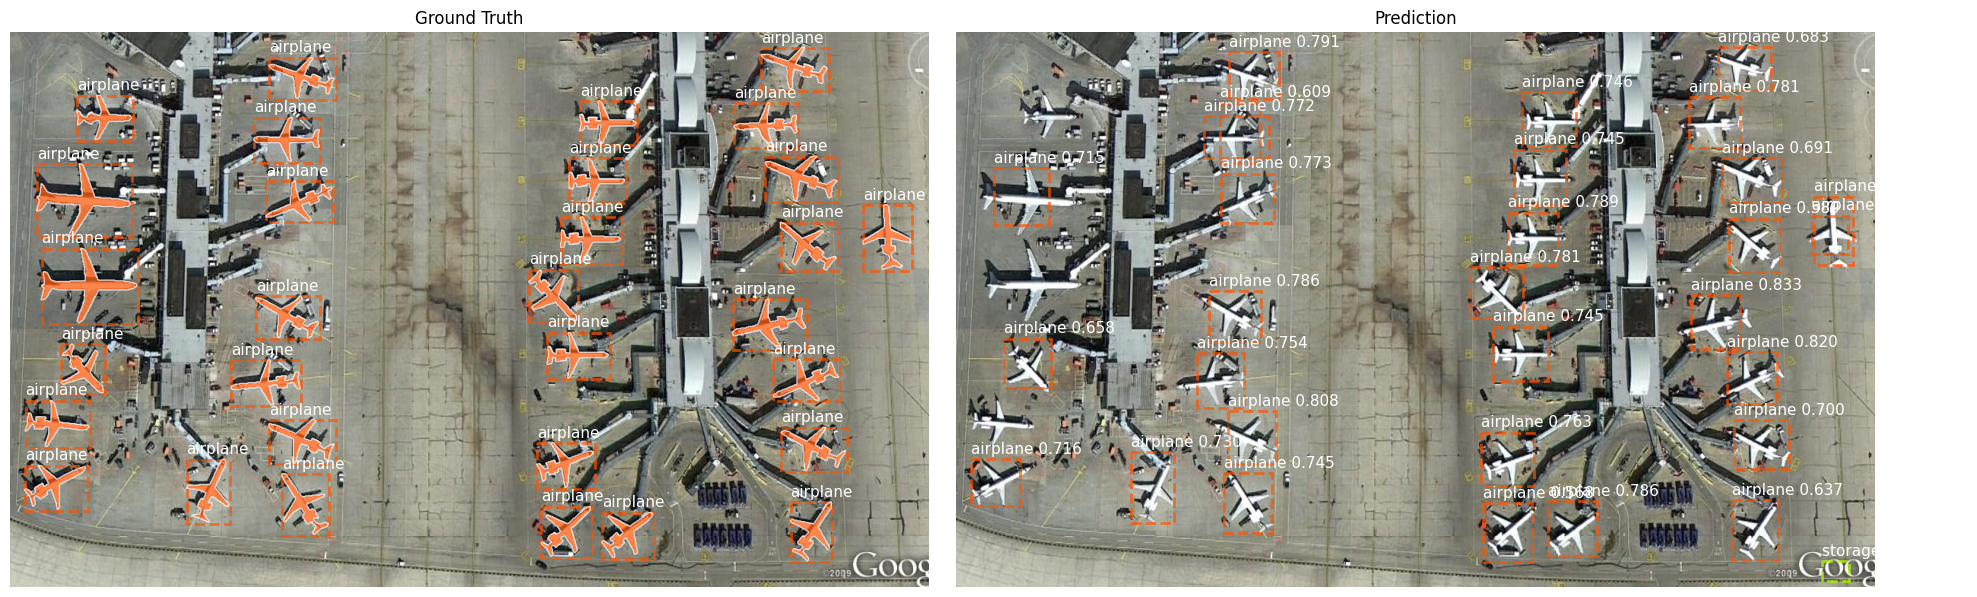

In [ ]:
ds.plot(sample)
plt.show()
plt.close()